# Comparing methods of hurricane forecast uncertainty
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.1.0
##### date: 14 December 2021

```
conda create --name env-hurr-tfp python=3.9
conda activate env-hurr-tfp
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn 
pip install --upgrade palettable progressbar2 tabulate icecream flake8
pip install --upgrade keras-tuner sklearn
pip install --upgrade jupyterlab black isort jupyterlab_code_formatter
pip install silence-tensorflow
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from build_data import build_hurricane_data
from build_model import build_shash_model, build_bnn_model
from custom_loss import compute_shash_NLL, compute_NLL
from custom_metrics import CustomMAE, InterquartileCapture, SignTest
from model_diagnostics import plot_history
from save_model_run import save_model_run
from sklearn import preprocessing
from tensorflow.keras import optimizers
from training_instrumentation import TrainingInstrumentation
from silence_tensorflow import silence_tensorflow
import tensorflow_probability as tfp

silence_tensorflow()

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "14 December 2021"

EXP_NAME = "intensity0_AL72"

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

settings = experiment_settings.get_settings(EXP_NAME)
pprint.pprint(settings, width=80)

{'act_fun': 'relu',
 'basin': 'AL',
 'batch_size': 64,
 'filename': 'nnfit_vlist_intensity_and_track_extended.dat',
 'hiddens': [15, 10],
 'leadtime': 72,
 'learning_rate': 0.0001,
 'loss': 'likelihood',
 'momentum': 0.9,
 'n_epochs': 25000,
 'n_test': 0,
 'n_val': 300,
 'nesterov': True,
 'patience': 300,
 'ridge_param': 0.0,
 'rng_seed': 888,
 'target': 'intensity',
 'uncertainty_type': 'shash3',
 'undersample': False}


## Build the intensity data tensors.

In [4]:
(
    x_train,
    onehot_train,
    x_val,
    onehot_val,
    data_summary,
    df,
) = build_hurricane_data(DATA_PATH, settings, verbose=2)

{'datafile_path': 'data/nnfit_vlist_intensity_and_track_extended.dat',
 'onehot_train_shape': (872, 3),
 'onehot_val_shape': (300, 3),
 'x_names': ['NCI',
             'DSDV',
             'LGDV',
             'HWDV',
             'AVDV',
             'VMXC',
             'DV12',
             'SLAT',
             'SSTN',
             'SHDC',
             'DTL'],
 'x_train_shape': (872, 11),
 'x_val_shape': (300, 11),
 'y_name': ['OBDV']}


         |   cnt |   min |   25% |   50% |   75% |   max |   avg |   std |   irq
---------+-------+-------+-------+-------+-------+-------+-------+-------+-------
 y_train |   872 | -37.8 |  -7.5 |   0.5 |  10.0 |  72.5 |  3.05 | 16.66 |  17.5
 y_val   |   300 | -39.2 |  -6.0 |   0.8 |   9.9 |  69.5 |  4.06 | 17.41 |  15.9




## Define the callbacks

In [5]:
earlystoping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=settings["patience"],
    restore_best_weights=True,
    verbose=1,
)

training_callback = TrainingInstrumentation(
    x_train,
    onehot_train,
    interval=10,
)

callbacks = [earlystoping_callback, training_callback]

## Train the model

In [6]:
NETWORK_SEED_LIST = [settings["rng_seed"]]

# NETWORK_SEED_LIST = [
#     18311, 59811, 96605, 57122, 71786, 67878, 33152, 22416, 81168, 27531,
#     52157,   455, 98106, 37162, 58090, 90264, 25338, 27555, 92859, 13387,
#     74723, 19736, 36842, 68050, 59711, 95199, 66418, 68997, 53431, 37786,
#     79742, 74042,  8347, 49338, 96884, 14870, 88326,   921, 79436, 23564,
#     2171,  89287, 31264, 22974, 31029, 97532,  4118, 20170, 77804, 67085,
#     24752, 29814, 62255, 23602,  9709, 76607, 49259, 32678, 56290, 53251,
#     66300, 40562, 10800, 94890, 14329, 94699, 43680, 71747, 64795, 68908,
#     50914, 43933, 63123, 62693, 48125,  1701, 15552, 25529, 54440,  4657,
#     9542,  77033, 96934, 49582, 34698, 82159, 20147, 83905, 17808, 21539,
#     59896, 70793, 97321, 92170, 24675, 82172, 24226, 30460, 53389, 61562,
# ]

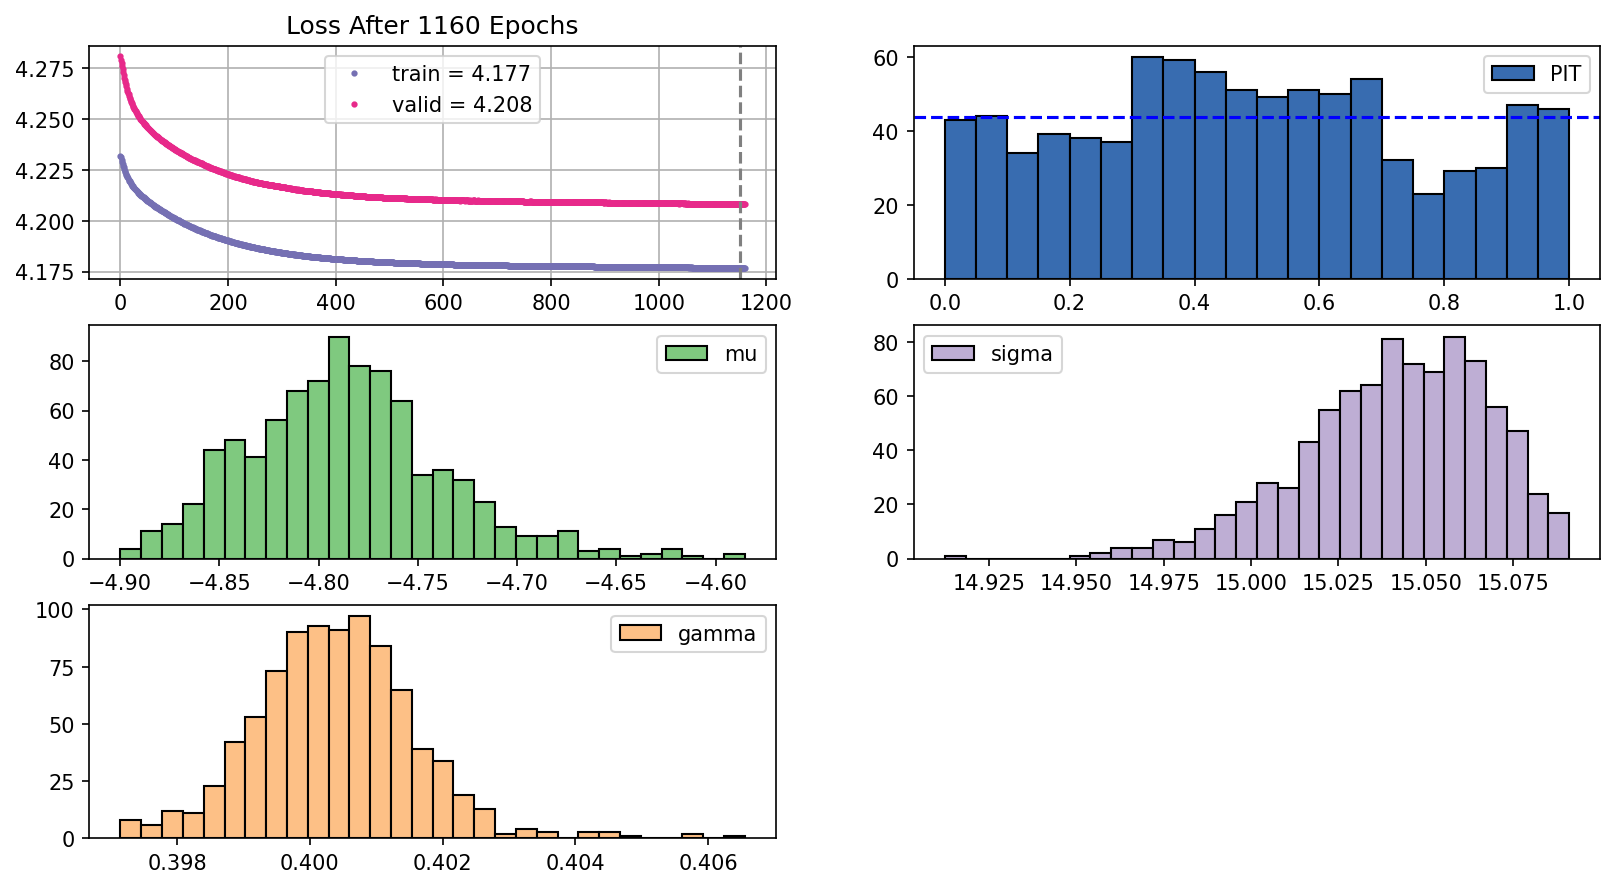

In [ ]:
for network_seed in NETWORK_SEED_LIST:
    tf.random.set_seed(network_seed)  # This sets the global random seed.

    # Create the model name.
    model_name = (
        EXP_NAME + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
    )
    pprint.pprint(model_name)

    # Make, compile, and train the model
    tf.keras.backend.clear_session()

    if settings["uncertainty_type"] == "bnn":       
        model = build_bnn_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )        
        
        model.compile(
            optimizer=optimizers.Adam(
                learning_rate=settings["learning_rate"],
            ),
            loss=compute_NLL,
        )        
        
    elif settings["uncertainty_type"][:5] == "shash":   
        model = build_shash_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )

        model.compile(
            optimizer=optimizers.SGD(
                learning_rate=settings["learning_rate"],
                momentum=settings["momentum"],
                nesterov=settings["nesterov"],
            ),
            loss=compute_shash_NLL,
            metrics=[
                CustomMAE(name="custom_mae"),
                InterquartileCapture(name="interquartile_capture"),
                SignTest(name="sign_test"),
            ],
        )

        
    model.summary()

    start_time = time.time()
    history = model.fit(
        x_train,
        onehot_train,
        validation_data=(x_val, onehot_val),
        batch_size=settings["batch_size"],
        epochs=settings["n_epochs"],
        shuffle=True,
        verbose=0,
        callbacks=callbacks,
    )
    stop_time = time.time()

    # Display the results, and save the model rum.
    best_epoch = np.argmin(history.history["val_loss"])
    fit_summary = {
        "network_seed": network_seed,
        "elased_time": stop_time - start_time,
        "best_epoch": best_epoch,
        "loss_train": history.history["loss"][best_epoch],
        "loss_valid": history.history["val_loss"][best_epoch],
    }
    pprint.pprint(fit_summary, width=80)
    plot_history(history, model_name)

    save_model_run(
        data_summary,
        fit_summary,
        model,
        MODEL_PATH,
        model_name,
        settings,
        __version__,
    )

In [ ]:
print("\n" + EXP_NAME + " training complete.")

In [ ]:
history.history.keys()

In [ ]:
# import matplotlib.pyplot as plt
# import shash
# index = 5

# mu_pred,sigma_pred,gamma_pred = model.predict(x_val[index,:]).T

# shash_cpd = shash.rvs(mu_pred,sigma_pred,gamma_pred,np.ones(np.shape(mu_pred)),size=200)
# plt.hist(shash_cpd,bins=np.arange(-80,90,10))
# plt.axvline(x=onehot_val[index,0],color='orange')

# out_pred = model.predict(x_val)
# mu = out_pred[:,0]
# sigma = out_pred[:,1]
# gamma = out_pred[:,2]
# tau = np.ones(np.shape(mu))

# F = shash.cdf(onehot_val[:, 0], mu, sigma, gamma, tau)
# plt.subplot(1, 1, 1)
# plt.hist(
#     F.numpy(),
#     bins=np.linspace(0, 1, 21),
#     color="#386cb0",
#     edgecolor="k",
# )
# plt.legend(["PIT"])
# plt.axhline(y=F.shape[0] / 20, color="b", linestyle="--")